In [1]:
import os
import cv2  
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
import numpy as np
import time


In [2]:
dataset_path = 'leapGestRecog'

In [3]:
gesture_map = {
    'palm': 0, 'l': 1, 'fist': 2, 'fist_moved': 3, 'thumb': 4,
    'index': 5, 'ok': 6, 'palm_moved': 7, 'c': 8, 'down': 9
}
gesture_labels = ['palm', 'L', 'fist', 'fist_moved', 'thumb', 
                  'index', 'ok', 'palm_moved', 'c', 'down']

# lists to store the data and labels
data = []
labels = []

Here i preprocess and organize the dataset for hand gesture recognition. The dataset is structured in folders where each folder represents a different subject, and within each subject folder, there are subfolders for different hand gestures. The code extracts images from these folders, assigns labels to the images based on the gesture, and prepares the data for training a machine learning model.


In [3]:
for subject_folder in os.listdir(dataset_path):
    subject_path = os.path.join(dataset_path, subject_folder)
    
    if os.path.isdir(subject_path):
        for gesture_folder in os.listdir(subject_path):
            gesture_path = os.path.join(subject_path, gesture_folder)
            
            gesture_name = gesture_folder.split('_')[1]
            
            if gesture_name in gesture_map:
                gesture_label = gesture_map[gesture_name]
                
                for img_name in os.listdir(gesture_path):
                    img_path = os.path.join(gesture_path, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
                    
                    if img is not None:
                        data.append(img)
                        labels.append(gesture_label)  # Assign label based on gesture name

data = np.array(data)
labels = np.array(labels)


In [4]:
print(f'Total images loaded: {len(data)}')
print(f'Sample image shape: {data[0].shape}')

Total images loaded: 20000
Sample image shape: (240, 640)


normalization of pixel values and reshaping the data to be compatible with the model input requirements.

Purpose: Normalize the pixel values of the images by scaling them between 0 and 1

In [5]:
data_normalized = data / 255.0

# for grayscale images
data_normalized = data_normalized.reshape(data_normalized.shape[0], 240, 640, 1)


This code is used to preprocess images by resizing them to a smaller resolution, normalizing pixel values, and reshaping the data to prepare it for training the machine learning model.

In [6]:
data_resized = []
for img in data:
    resized_img = cv2.resize(img, (320, 120))  # Resize to 120x320
    data_resized.append(resized_img)

data_resized = np.array(data_resized) / 255.0
data_resized = data_resized.reshape(data_resized.shape[0], 120, 320, 1)

np.save('X_data_resized.npy', data_resized)
np.save('y_labels.npy', labels)

X_train_resized, X_test_resized, y_train, y_test = train_test_split(data_resized, labels, test_size=0.2, random_state=42)

np.save('X_train_resized.npy', X_train_resized)
np.save('X_test_resized.npy', X_test_resized)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

print(f'Training set size: {X_train_resized.shape[0]}')
print(f'Test set size: {X_test_resized.shape[0]}')

Training set size: 16000
Test set size: 4000


In [4]:
X_train_resized = np.load('X_train_resized.npy')
X_test_resized = np.load('X_test_resized.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
labels = np.load('y_labels.npy')

## Model Architecture
This code defines a Convolutional Neural Network (CNN) model using Keras with a series of convolutional and pooling layers, followed by fully connected layers. The model starts with three convolutional layers, each followed by max pooling, to progressively extract features from the input images, with a reduction in the number of filters per layer to manage model complexity. The output of the convolutional layers is flattened and passed through a dense layer with fewer neurons to further process the features, and a dropout layer is included to prevent overfitting. Finally, the model concludes with a dense output layer with 10 units and a softmax activation function to classify the images into one of 10 gesture categories. The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss, and it is ready for training on gesture recognition tasks.

In [36]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(120, 320, 1)))  # Reduced from 32 to 16
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))  # Reduced from 64 to 32
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))  # Reduced from 128 to 64
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))  # Reduced from 128 to 64

model.add(Dropout(0.5))

# Output layer (10 gestures)
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 118, 318, 16)      160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 59, 159, 16)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 157, 32)       4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 78, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 76, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 38, 64)      

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    X_train_resized, y_train,
    validation_data=(X_test_resized, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
500/500 [==============================] - 99s 196ms/step - loss: 0.3993 - accuracy: 0.8597 - val_loss: 0.0087 - val_accuracy: 0.9977
Epoch 2/20
500/500 [==============================] - 107s 213ms/step - loss: 0.0862 - accuracy: 0.9703 - val_loss: 0.0059 - val_accuracy: 0.9987
Epoch 3/20
500/500 [==============================] - 127s 255ms/step - loss: 0.0555 - accuracy: 0.9801 - val_loss: 0.0048 - val_accuracy: 0.9992
Epoch 4/20
500/500 [==============================] - 114s 229ms/step - loss: 0.0461 - accuracy: 0.9837 - val_loss: 0.0023 - val_accuracy: 0.9995
Epoch 5/20
500/500 [==============================] - 115s 230ms/step - loss: 0.0404 - accuracy: 0.9851 - val_loss: 3.2201e-04 - val_accuracy: 1.0000
Epoch 6/20
500/500 [==============================] - 98s 197ms/step - loss: 0.0316 - accuracy: 0.9881 - val_loss: 1.6259e-04 - val_accuracy: 1.0000
Epoch 7/20
500/500 [==============================] - 82s 164ms/step - loss: 0.0254 - accuracy: 0.9904 - val_loss: 3.9

The training results indicate exceptional performance of the model, achieving a training accuracy of 99.61% with a very low training loss of 0.0109, suggesting that the model has learned to classify gestures very effectively on the training data. The validation accuracy is 100%, with a negligible validation loss of 7.4536e-06, indicating that the model generalizes well to unseen data and has not overfitted. These results highlight the model’s robustness and high accuracy in gesture recognition, as it performs excellently on both the training and validation datasets.

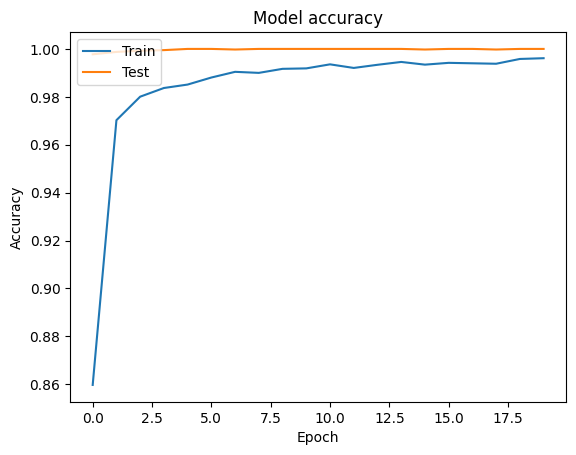

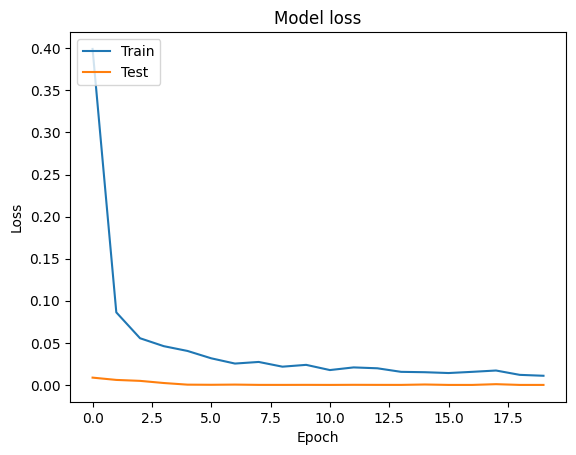

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [8]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

In [39]:
test_loss, test_accuracy = model.evaluate(X_test_resized, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

125/125 [==============================] - 4s 34ms/step - loss: 7.4536e-06 - accuracy: 1.0000
Test Accuracy: 100.00%


The test results demonstrate that the model achieved a perfect test accuracy of 100% with a loss of 7.4536e-06, indicating flawless performance on the test dataset. The model's accuracy of 100% suggests that it correctly classified all test samples, while the extremely low loss value reflects minimal errors in predictions. These results highlight the model's excellent generalization capabilities and its effectiveness in accurately recognizing gestures.

In [ ]:
batch_size = 32  # Adjust the batch size according to your memory limitations
y_pred = model.predict(X_test_resized, batch_size=batch_size)

y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_classes,labels=range(len(labels)))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


class_report = classification_report(y_test, y_pred_classes, target_names=labels)
print("Classification Report:")
print(class_report)

Real-time Gesture Recognition testing

In [46]:
def preprocess_frame(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    resized_frame = cv2.resize(gray_frame, (320, 120))
    
    resized_frame = resized_frame / 255.0
    resized_frame = resized_frame.reshape(1, 120, 320, 1)
    
    return resized_frame


cap = cv2.VideoCapture(0)

print("Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    
    if not ret:
        print("Failed to grab frame.")
        break
    
    preprocessed_frame = preprocess_frame(frame)
    
    predictions = model.predict(preprocessed_frame)
    
    print(f"Raw predictions: {predictions}")
    
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = gesture_labels[predicted_class]  # Map the index to the gesture label
    
    print(f'Predicted Gesture: {predicted_label}')
    
    cv2.putText(frame, f'Gesture: {predicted_label}', (50, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    cv2.imshow('Real-time Hand Gesture Recognition', frame)
    
    time.sleep(0.1)  # Adjust delay if needed
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Press 'q' to quit.
1/1 [==============================] - 0s 17ms/step
Raw predictions: [[5.2673910e-05 8.5695172e-03 9.1855562e-01 2.2407360e-09 3.3974778e-04
  3.3818174e-02 6.0032721e-09 3.6986023e-08 1.6688573e-07 3.8664058e-02]]
Predicted Gesture: fist
1/1 [==============================] - 0s 20ms/step
Raw predictions: [[4.7425234e-05 5.5113798e-03 9.2671865e-01 1.6728381e-09 2.7714664e-04
  3.4398068e-02 3.6853738e-09 2.6735306e-08 1.6827489e-07 3.3047203e-02]]
Predicted Gesture: fist
1/1 [==============================] - 0s 22ms/step
Raw predictions: [[3.4136396e-05 4.5530675e-03 9.0931487e-01 1.9543260e-09 4.5207553e-04
  3.2149509e-02 4.5536965e-09 3.2694128e-08 2.3960322e-07 5.3496111e-02]]
Predicted Gesture: fist
1/1 [==============================] - 0s 21ms/step
Raw predictions: [[7.9454418e-05 8.6297970e-03 8.0513692e-01 1.3488082e-08 1.3901014e-03
  6.1520442e-02 2.8528085e-08 1.7348059e-07 9.2527614e-07 1.2324225e-01]]
Predicted Gesture: fist
1/1 [====================

Image gesture recognition test

In [27]:
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize the image to match model input (120x320)
    resized_img = cv2.resize(img, (320, 120))
    
    # Normalize the image (scale pixel values between 0 and 1)
    resized_img = resized_img / 255.0
    
    # Reshape for model input (batch size, height, width, channels)
    resized_img = resized_img.reshape(1, 120, 320, 1)
    
    return resized_img

# Path to the test image
image_path = ''

# Preprocess the image
preprocessed_image = preprocess_image(image_path)

# Predict gesture using the trained model
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Get the predicted gesture label
predicted_label = labels[predicted_class]

# Print the prediction result
print(f'The predicted gesture is: {predicted_label}')

1/1 [==============================] - 0s 27ms/step
The predicted gesture is: 0


In [28]:
predictions = model.predict(preprocessed_image)
print(f'Raw predictions: {predictions}')
predicted_class = np.argmax(predictions, axis=1)[0]
print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 0s 24ms/step
Raw predictions: [[4.6112094e-26 4.8779886e-28 6.2430222e-12 2.0751556e-33 3.5180858e-27
  1.0519675e-24 1.6045188e-23 5.1891982e-31 1.0000000e+00 8.8915744e-23]]
Predicted class: 8


In [29]:
predicted_class = np.argmax(predictions, axis=1)[0]
predicted_label = gesture_labels[predicted_class]

print(f'Predicted class: {predicted_class} -> Gesture: {predicted_label}')

Predicted class: 8 -> Gesture: c
